# for Part B training

ref:https://colab.research.google.com/github/googlecodelabs/odml-pathways/blob/main/audio_classification/colab/model_maker_audio_colab.ipynb

In [1]:
! pip install tflite-model-maker tensorflow==2.5

     |████████████████████████████████| 616 kB 13.3 MB/s 
     |████████████████████████████████| 454.3 MB 19 kB/s 
     |████████████████████████████████| 1.2 MB 60.2 MB/s 
     |████████████████████████████████| 462 kB 55.3 MB/s 
     |████████████████████████████████| 132 kB 41.5 MB/s 
     |████████████████████████████████| 14.8 MB 58.9 MB/s 
     |████████████████████████████████| 4.0 MB 48.5 MB/s 
     |████████████████████████████████| 120 kB 73.7 MB/s 
     |████████████████████████████████| 237 kB 75.3 MB/s 
     |████████████████████████████████| 616 kB 74.1 MB/s 
     |████████████████████████████████| 591 kB 73.1 MB/s 
     |████████████████████████████████| 840 kB 75.6 MB/s 
     |████████████████████████████████| 596 kB 76.2 MB/s 
     |████████████████████████████████| 87 kB 6.5 MB/s 
     |████████████████████████████████| 6.4 MB 55.6 MB/s 
     |████████████████████████████████| 77 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 66.6 MB/s 
     |███████████

In [2]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


TensorFlow Version: 2.5.0
Model Maker Version: 0.3.2


In [3]:
birds_dataset_folder = tf.keras.utils.get_file('birds_dataset.zip',
                                                'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/birds_dataset.zip',
                                                cache_dir='./',
                                                cache_subdir='dataset',
                                                extract=True)
                                                

343687168/343680986 [==============================] - 6s 0us/step


In [ ]:
# @title [Run this] Util functions and data structures.

data_dir = './dataset/small_birds_dataset'

bird_code_to_name = {
  'wbwwre1': 'White-breasted Wood-Wren',
  'houspa': 'House Sparrow',
  'redcro': 'Red Crossbill',  
  'chcant2': 'Chestnut-crowned Antpitta',
  'azaspi1': "Azara's Spinetail",   
}

birds_images = {
  'wbwwre1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg/640px-Henicorhina_leucosticta_%28Cucarachero_pechiblanco%29_-_Juvenil_%2814037225664%29.jpg', # 	Alejandro Bayer Tamayo from Armenia, Colombia 
  'houspa': 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/52/House_Sparrow%2C_England_-_May_09.jpg/571px-House_Sparrow%2C_England_-_May_09.jpg', # 	Diliff
  'redcro': 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/49/Red_Crossbills_%28Male%29.jpg/640px-Red_Crossbills_%28Male%29.jpg', #  Elaine R. Wilson, www.naturespicsonline.com
  'chcant2': 'https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Chestnut-crowned_antpitta_%2846933264335%29.jpg/640px-Chestnut-crowned_antpitta_%2846933264335%29.jpg', # 	Mike's Birds from Riverside, CA, US
  'azaspi1': 'https://upload.wikimedia.org/wikipedia/commons/thumb/b/b2/Synallaxis_azarae_76608368.jpg/640px-Synallaxis_azarae_76608368.jpg', # https://www.inaturalist.org/photos/76608368
}

test_files = os.path.join('/content', data_dir, 'test/*/*.wav')

def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_bird_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')

  bird_code = audio_path.split('/')[-2]
  print(f'Bird name: {bird_code_to_name[bird_code]}')
  print(f'Bird code: {bird_code}')
  display(Image(birds_images[bird_code]))

  plttitle = f'{bird_code_to_name[bird_code]} ({bird_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

Bird name: Red Crossbill
Bird code: redcro


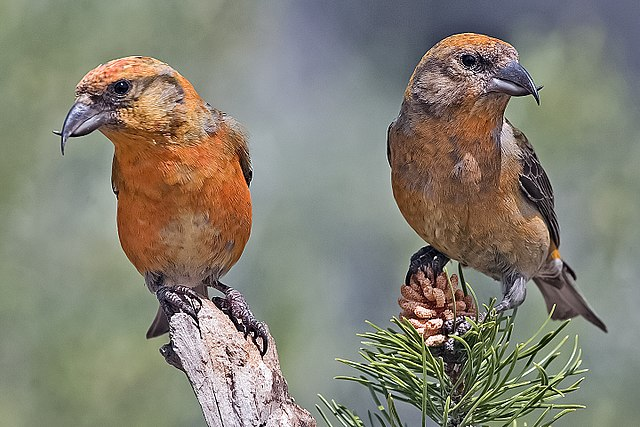

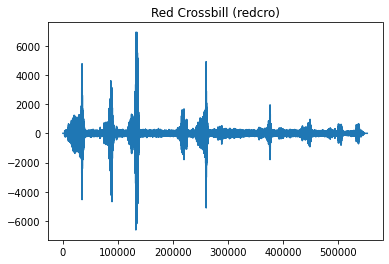

In [13]:
random_audio = get_random_audio_file()
show_bird_data(random_audio)

In [5]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=True,
    frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmpz_4pp8qy


In [6]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [7]:
batch_size = 128
epochs = 100

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
classification_head (Dense)  (None, 5)                 5125      
Total params: 5,125
Trainable params: 5,125
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
23/23 [==============================] - 198s 8s/step - loss: 1.5721 - acc: 0.3026 - val_loss: 1.4987 - val_acc: 0.3498
Epoch 2/100
23/23 [==============================] - 1s 28ms/step - loss: 1.2801 - acc: 0.4997 - val_loss: 1.3705 - val_acc: 0.4208
Epoch 3/100
23/23 [==============================] - 1s 31ms/step - loss: 1.1166 - acc: 0.6048 - val_loss: 1.2648 - val_acc: 0.5033
Epoch 4/100
23/23 [==============================] - 1s 30ms/step - loss: 1.0110 - acc: 0.6619 - val_loss: 1.1918 - val_acc: 0.5231
Epoch 5/100
23/23 [==============================] - 1s 27ms/step - loss: 0.9261 - acc: 0.7068 - val_

In [8]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
28/28 [==============================] - 47s 2s/step - loss: 0.8192 - acc: 0.7887


[0.8191953897476196, 0.788748562335968]

In [9]:
models_path = './birds_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='my_birds_model.tflite')

Exporing the TFLite model to ./birds_models


INFO:tensorflow:Assets written to: /tmp/tmplgjqrpj1/assets


INFO:tensorflow:Assets written to: /tmp/tmplgjqrpj1/assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./birds_models/my_birds_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./birds_models/my_birds_model.tflite


# New Section